<a href="https://www.kaggle.com/code/soumyadas96/pubg-game-prediction-catboost-model?scriptVersionId=186786731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <center><font color = "green">PUBG Game Prediction</font></center>


<center><img src = "https://media.giphy.com/media/XVbrX433vn6rqkexSj/giphy.gif"></center>

## <font color = "green">About Dataset:</font>

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 players per group.

### <font color = "green">Link to dataset:</font>

 - Kaggle - https://www.kaggle.com/datasets/ashishjangra27/pubg-games-dataset

## <font color = "green">Data Description:</font>

- **DBNOs -** Number of enemy players knocked.
- **assists -** Number of enemy players this player damaged that were killed by teammates.
- **boosts -** Number of boost items used.
- **damageDealt -** Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills -** Number of enemy players killed with headshots.
- **heals -** Number of healing items used.
- **Id -** Player’s Id
- **killPlace -** Ranking in match of number of enemy players killed.
- **killPoints -** Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks -** Max number of enemy players killed in a short amount of time.
- **kills -** Number of enemy players killed.
- **longestKill -** Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration -** Duration of match in seconds.
- **matchId -** ID to identify match. There are no matches that are in both the training and testing set.
- **matchType -** String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints -** Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives -** Number of times this player revived teammates.
- **rideDistance -** Total distance traveled in vehicles measured in meters.
- **roadKills -** Number of kills while in a vehicle.
- **swimDistance -** Total distance traveled by swimming measured in meters.
- **teamKills -** Number of times this player killed a teammate.
- **vehicleDestroys -** Number of vehicles destroyed.
- **walkDistance -** Total distance traveled on foot measured in meters.- 
- **weaponsAcquired -** Number of weapons picked up.
- **winPoints -** Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- **groupId -** ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups -** Number of groups we have data for in the match.
- **maxPlace -** Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc -** The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

### <font color = "green">Tool and Libraries Used:</font>

- **Tool:**
  - Python 3.11.7
- **Standard Libraries:**
  - warnings
  - numpy (imported as np)
  - pandas (imported as pd)
- **Visualization Libraries:**
  - matplotlib.pyplot (imported as plt)
  - seaborn (imported as sns)
- **Machine Learning Libraries:**
  - sklearn.preprocessing (specifically StandardScaler)
  - sklearn.model_selection (specifically train_test_split)
  - catboost (imported as cb)
  - sklearn.metrics (specifically mean_squared_error and r2_score)

### <font color = "green">Table of Content</font><a class = "anchor" id = "content"></a>

1. [Importing Libraries](#import)
2. [Importing Data](#importdata)
3. [Reading Data](#read)
4. [Data Wrangling](#wrangle)
5. [Feature Engineering](#feature)
6. [ML - CatBoost Model](#cat)
  - [CatBoost Model](#catboost)
  - [Prediction](#prediction)

# <font color = "green">Importing Libraries</font><a class = "anchor" id = "import"></a>

In [1]:
## handling warnings

import warnings
warnings.filterwarnings("ignore")

##standard libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## visualisation

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (11,5)

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## !pip install catboost (for jupyter/colab)

import catboost as cb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

[🔝](#content)

# <font color = "green">Importing the Data </font><a class = "anchor" id = "importdata"></a>


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv


[🔝](#content)

# <font color = "green">Reading the Data </font><a class = "anchor" id = "read"></a>

In [3]:
## load the data

df = pd.read_csv("/kaggle/input/pubg-games-dataset/PUBG_Game_Prediction_data.csv")

## glimpse of the data

df.head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.8,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.0,5,0,0.6400


In [4]:
## data dimension

df.shape

(4446966, 29)

In [5]:
## data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

[🔝](#content)

# <font color = "green">Data Wrangling</font><a class = "anchor" id = "wrangle"></a>

#### Check for the rows with missing win prediction value

In [6]:
## check row with NULL win prediction value

df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [7]:
## remove the data row - 2744604

df.drop(2744604, inplace = True)

#### Understanding Players distribution in a game

In [8]:
## prepare new parameter to know how many players are in a game

df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
df.head(1)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.0,0,0,0,60,...,0.0,0,0.0,0,0,244.8,1,1466,0.4444,96


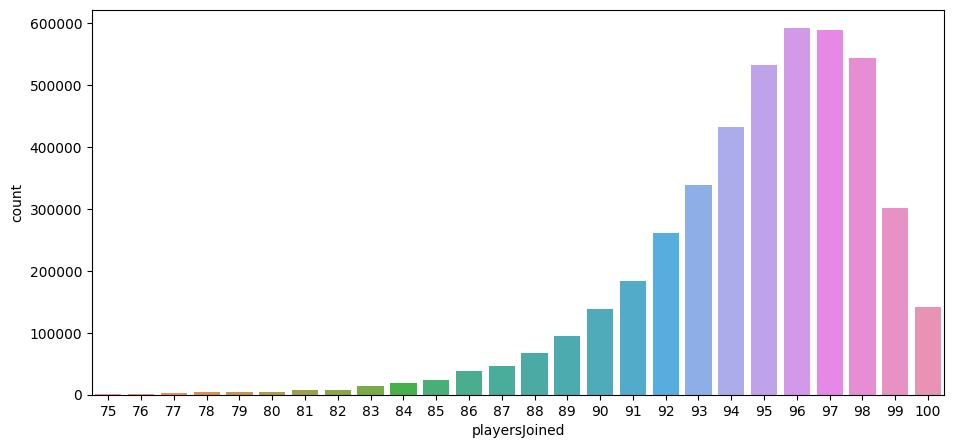

In [9]:
## visualize matches where players joined >= 75

sns.countplot(data = df[df['playersJoined']>=75],x = 'playersJoined')
plt.show()

###### Observation:
The data for 75 and + people in a match is huge with maximum matches having 95-98 players

## Analysing the data

#### Kills Without Moving?

###### It is not possible to kill even 1 player if you do not move by atleast 1 unit. Following are mostly used practices by cheaters (ones who interfere with the game's genuine natural processes):
* Aimbots
* Wallhacks
* Triggerbots
* ESP (Extra Sensory Perception)
* Silent Aim

In [10]:
## prepare a data parameter to gather the information of the total distance travelled

df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

## prepare a data parameter to check for anamoly detection that
## the person has not moved but still managed to do the kills

df['killswithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0))

In [11]:
## check data for people who have killed without moving

df[df['killswithoutMoving'] == True].head(2)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutMoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True


In [12]:
## check total kills without moving data

df[df['killswithoutMoving'] == True].shape

(1535, 32)

###### Observation:
1535 instances have either used hacks or been lucky ! We cannot use such data (which cannot be generalised) for our model. Hence, dropping these instances.

In [13]:
## drop the instances

df.drop(df[df['killswithoutMoving'] == True].index , inplace = True)

#### Extra-ordinary Road Kills !

In [14]:
## check data for roadkills > 5

df[df['roadKills'] > 5].shape

(46, 32)

###### Observation:
It takes to be expert among the other players in a match to kill by vehicles only. Hence dropping the 46 instances from data frame.

In [15]:
## drop the instance

df.drop(df[df['roadKills'] > 5].index, inplace = True)

#### So many KILLS - how ???

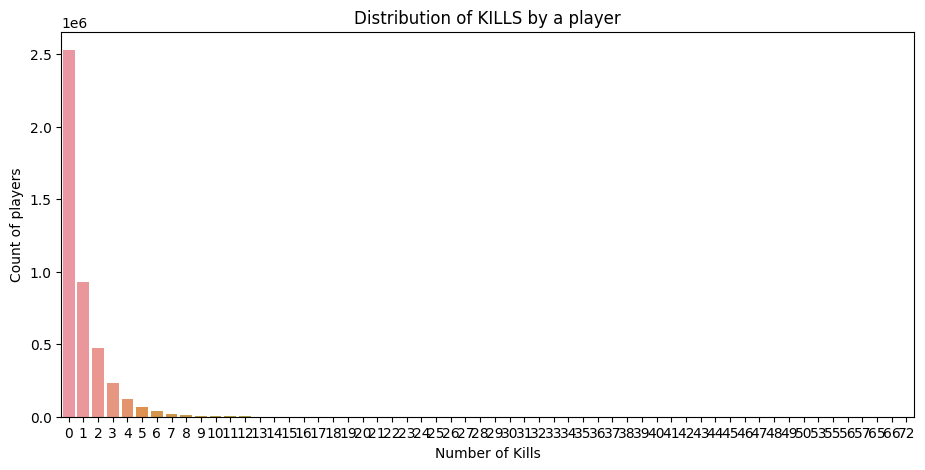

In [16]:
## visualize data for No. of players | Kills

sns.countplot(data = df, x = df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

###### Observation:
Maximum people kills upto maximum 12 players.

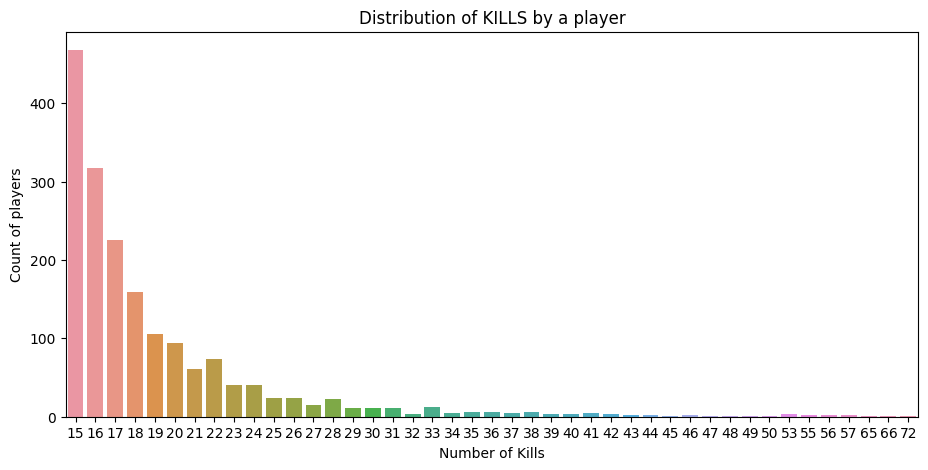

In [17]:
## visualize data for No. of players | Kills >= 15

sns.countplot(data = df[df['kills']>=15],x='kills').set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of Kills")
plt.show()

In [18]:
## kills > 20 cannot be generalized

df[df['kills'] > 20].shape

(417, 32)

###### Observation:
Kills beyond 20 are rare and cannot be used a general use case. Hence, dropping the instance.

In [19]:
## drop the instances

df.drop(df[df['kills'] > 20].index, inplace = True)

#### Head Shot

<center><img src = "https://media.giphy.com/media/l3mZrOajz5VCZf7Hy/giphy.gif"></center>

In [20]:
## calculate headshot rate

df['headshot_rate'] = df['headshotKills']/df['kills']

## fill with 0 if there is not headshot

df['headshot_rate'] = df['headshot_rate'].fillna(0)

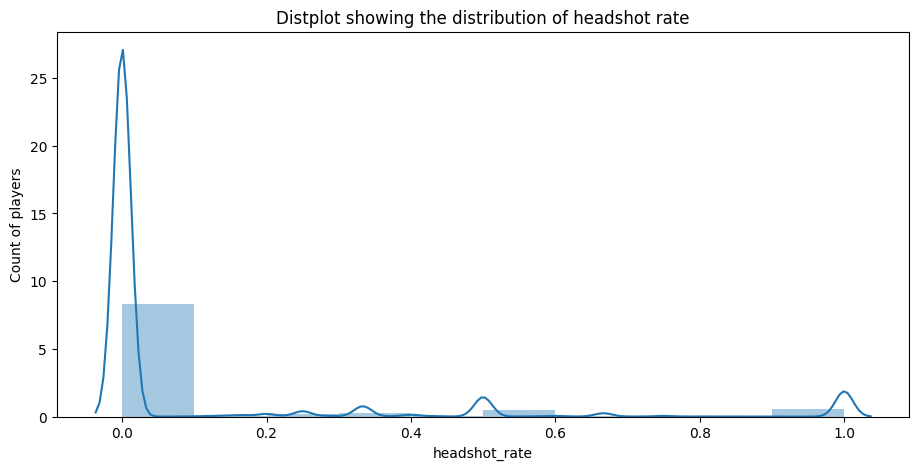

In [21]:
## plot the headshot rate distribution

sns.distplot(df['headshot_rate'], bins =10).set_title("Distplot showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [22]:
## find headshot rate == 100% with kills > 5

df[(df['headshot_rate'] == 1) & (df['kills'] > 5)].shape

(187, 33)

###### Observation
Killing more than 5 people as headshots where all the shots in a match are headshots is mostly not a general case. 187 instances have such anomaly and hence, we will drop them.

In [23]:
## droping the instances

df.drop(df[(df['headshot_rate'] == 1) & (df['kills'] > 6)].index, inplace = True)

#### Longest Shot

###### The maximum possible distance that is made possible to snipe from in PUBG is 1km or 1000 meters. However, this is not general case and most of the times, hackers use either of the following to take advantage and win a match:
* Sniper Aimbots
* Bullet Speed/Trajectory Hacks
* No Recoil/No Spread
* Zoom Hacks

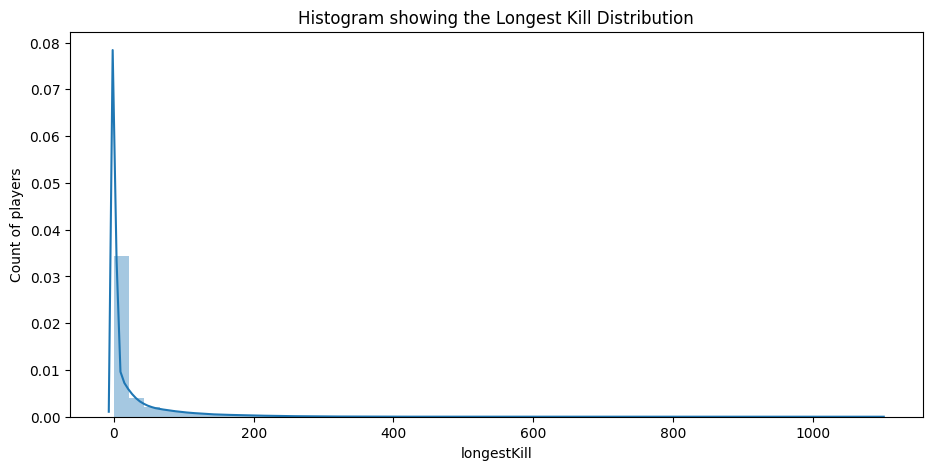

In [24]:
## visualize Number of people | Longest Kills

sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the Longest Kill Distribution")
plt.ylabel("Count of players")
plt.show()

In [25]:
## calculate instances with longestkill distance > 500 meters

df[df['longestKill']>=500].shape

(1747, 33)

###### Observation:
1747 instances have kills > 500. hence, we will drop these.

In [26]:
## dropping the instances

df.drop(df[df['longestKill']>=500].index, inplace = True)

#### Weapon Change

###### In general, people change upto 10 guns in match (avg. being 5 to 6). But, cheaters sometimes use either of the following for unlimited recoil/ guns in a single match:
* Macro Scripts
* Rapid Fire Hacks
* Input Spoofing

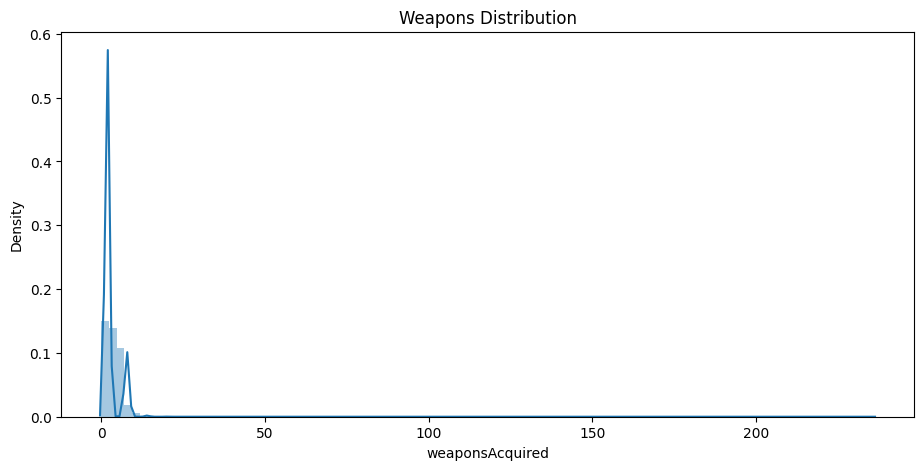

In [27]:
## visualize number of players | weapon change

sns.distplot(df['weaponsAcquired'], bins=100).set_title("Weapons Distribution")
plt.show()

In [28]:
## calculate instances with weapons acquired > 15

df[df['weaponsAcquired']>=15].shape

(6809, 33)

##### Observation:
In 6809 instances, people have changed gun more than 15 times in a match. Such is not a general the use case and hence, we will drop these values.

In [29]:
## drop instance

df.drop(df[df['weaponsAcquired']>=15].index, inplace = True)

### Exploratory Data Analysis

In [30]:
## final shape

df.shape

(4436306, 33)

In [31]:
## total number of null values

df.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          0
playersJoined         0
totalDistance         0
killswithoutMoving    0
headshot_rate         0
dtype: int64

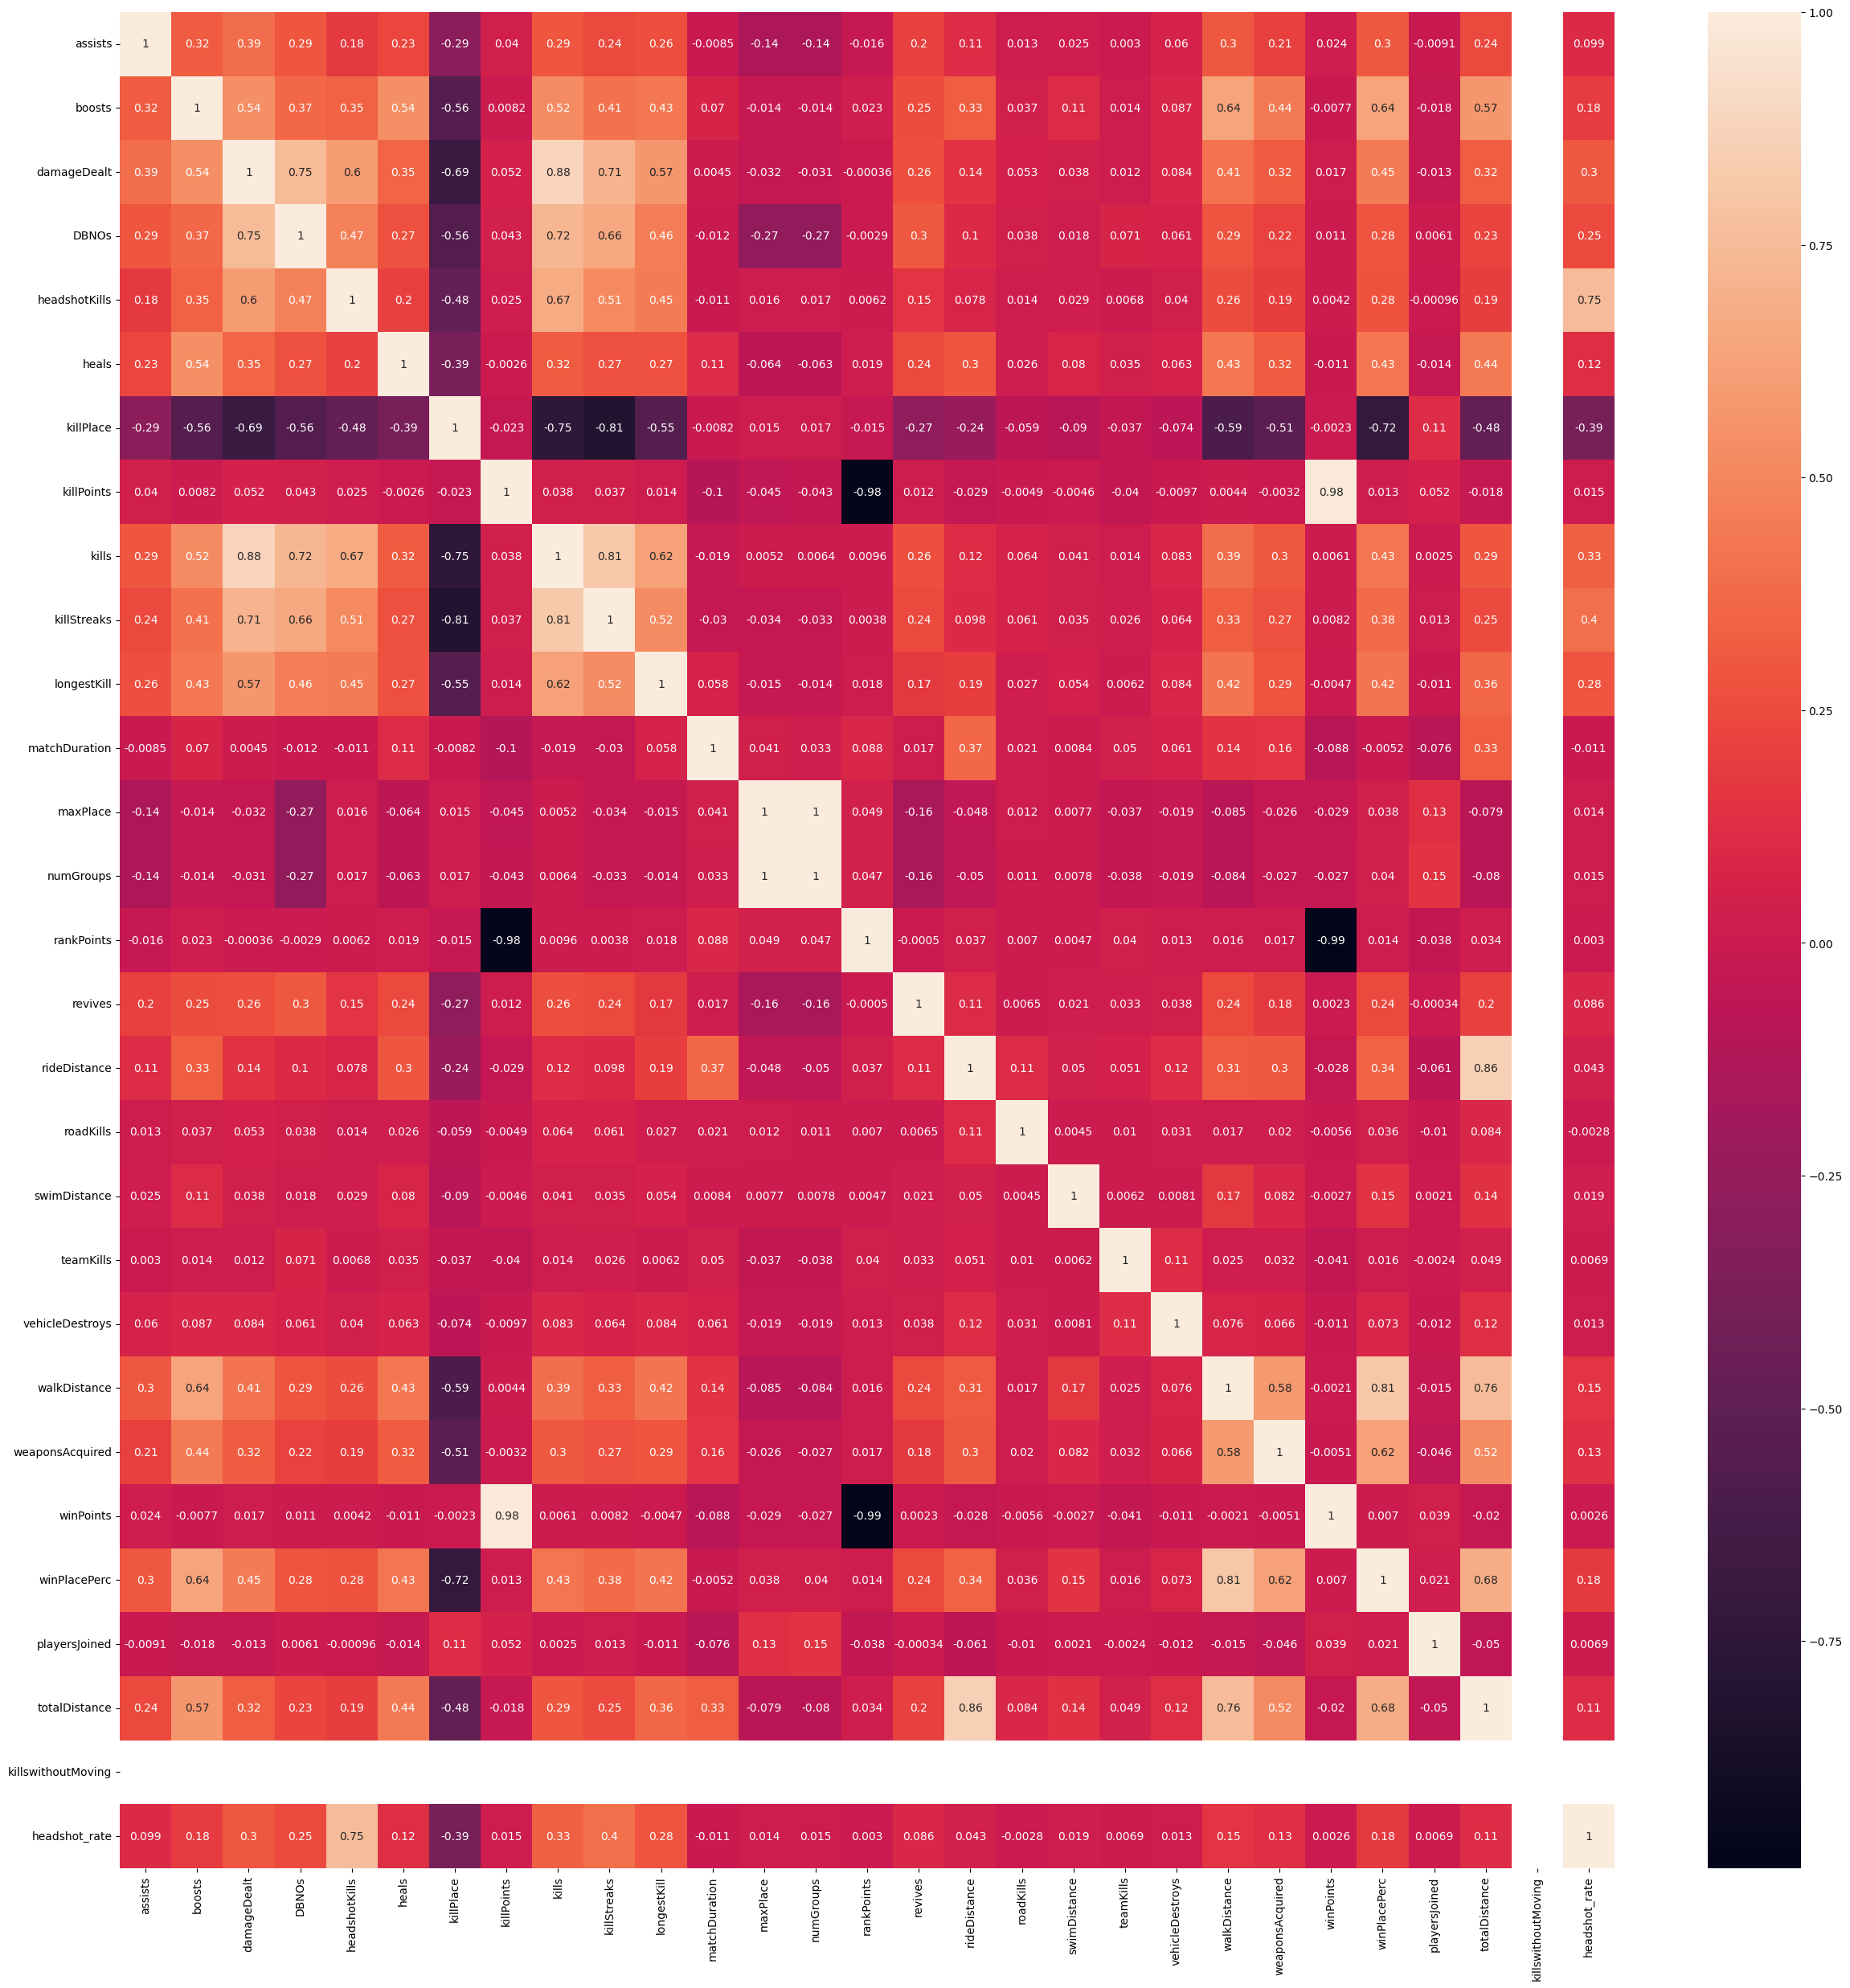

In [32]:
## correlation of parameter with Win Prediction

plt.figure(figsize=[30,30])
sns.heatmap(df.corr(numeric_only = True), annot = True)
plt.show()

[🔝](#content)

# <font color = "green">Feature Engineering</font><a class = "anchor" id = "feature"></a>

In [33]:
## calculate normalization factor
## (100-factor)/100 = 0 for matches including 100 players
## use (100-factor)/100 + 1

normalising_factor = (100 - df['playersJoined']/100)+1

In [34]:
## create new attributes with normalization factor

df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt'] * normalising_factor
df['maxPlaceNorm'] = df['maxPlace'] * normalising_factor
df['matchDurationNorm'] = df['matchDuration'] * normalising_factor
df['traveldistance'] = df['walkDistance']+ df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [35]:
## analyze columns

df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

#### Removing unwanted columns

In [36]:
## not tampering the cleaned data, creating important dataset

data = df.drop(columns = ['Id', 'groupId', 'matchId', 'assists', 'boosts', 'walkDistance', 'swimDistance',
                          'rideDistance', 'heals', 'revives', 'kills', 'damageDealt', 'maxPlace', 'matchDuration'])

In [37]:
## check data dataframe

data.head(2)

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutMoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.0,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.0,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.0,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.0,9155.2323,2602.34,177859.93,1445.0445,0,0


# <font color = "green">ML - Catboost Model</font><a class = "anchor" id = "cat"></a>

#### Handling categorical data

In [38]:
x = data.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

#### One-hot Encoding

In [39]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])
x = x.applymap(lambda x: int(x) if isinstance(x, bool) else x)
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


In [40]:
features = x.columns

#### Scaling the data

In [41]:
## prevent model from giving undue preference
## to instances with higher values

sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))
x.head(2)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.7651,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.7651,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0


#### Splitting data

In [42]:
## train and test within the single file

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 0)
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


##### Check:
<font  color = "Green">**Training Parameters:**</font> **3105414** <br>
<font  color = "Green">**Testing Parameters:**</font> **1330892** <br>

### <font color = "blue">CatBoost Model</font><a class = "anchor" id = "catboost"></a>

In [43]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [44]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [45]:
## GRID search
## run model one by one on all combinations
## return the best parameter combination

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]} ## runs 16 combinations here

model.grid_search(grid, train_dataset)

0:	learn: 0.5482016	test: 0.5479886	best: 0.5479886 (0)	total: 332ms	remaining: 32.9s
1:	learn: 0.5333650	test: 0.5331566	best: 0.5331566 (1)	total: 561ms	remaining: 27.5s
2:	learn: 0.5189826	test: 0.5187815	best: 0.5187815 (2)	total: 780ms	remaining: 25.2s
3:	learn: 0.5050844	test: 0.5048926	best: 0.5048926 (3)	total: 999ms	remaining: 24s
4:	learn: 0.4916276	test: 0.4914432	best: 0.4914432 (4)	total: 1.22s	remaining: 23.1s
5:	learn: 0.4786251	test: 0.4784449	best: 0.4784449 (5)	total: 1.44s	remaining: 22.6s
6:	learn: 0.4660267	test: 0.4658539	best: 0.4658539 (6)	total: 1.67s	remaining: 22.2s
7:	learn: 0.4538495	test: 0.4536820	best: 0.4536820 (7)	total: 1.91s	remaining: 22s
8:	learn: 0.4420341	test: 0.4418693	best: 0.4418693 (8)	total: 2.14s	remaining: 21.7s
9:	learn: 0.4306331	test: 0.4304748	best: 0.4304748 (9)	total: 2.36s	remaining: 21.2s
10:	learn: 0.4195967	test: 0.4194453	best: 0.4194453 (10)	total: 2.57s	remaining: 20.8s
11:	learn: 0.4089243	test: 0.4087765	best: 0.4087765 (11

{'params': {'depth': 8, 'learning_rate': 0.1, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

###### Observations:
Our model has prepare final data after Kfold cross validation.

**Best Parameters:**
 - 'depth': 8
 - 'learning_rate': 0.1
 - 'iterations': 150}
 - 'iterations': [0,....149]

In [46]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)
feature_importance_df

,features,importance
2,killPlace,40.804634
14,totalDistance,12.507865
20,traveldistance,11.786296
16,killsNorm,7.596194
4,killStreaks,7.568429
19,matchDurationNorm,5.355363
13,playersJoined,4.684276
6,numGroups,2.265490
21,healsnboosts,1.830046
5,longestKill,1.805096


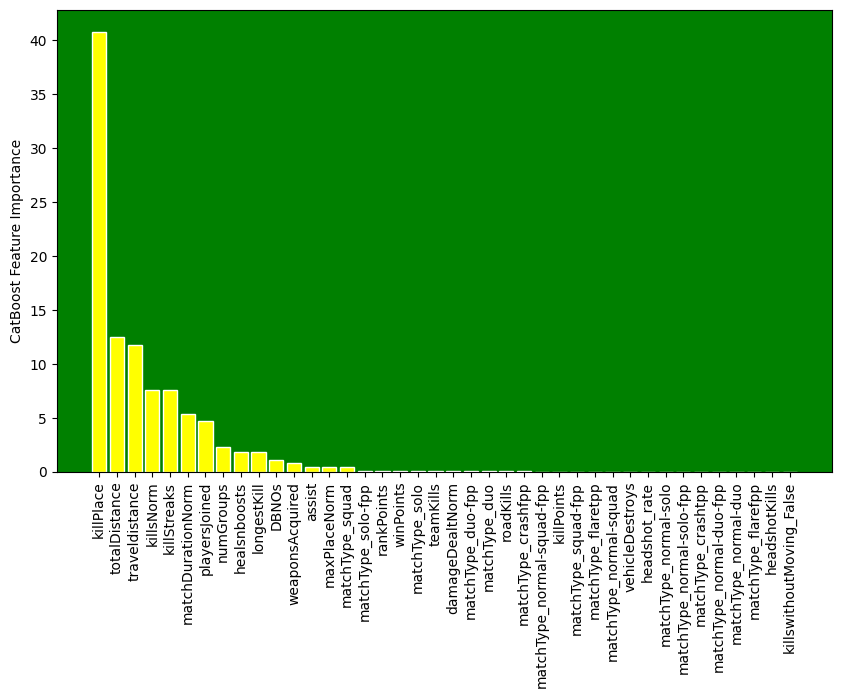

In [47]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Set the background color of the graph
plt.gca().set_facecolor('green')

# Plot the bar chart with specified colors
bars = plt.bar(feature_importance_df.features, feature_importance_df.importance, color='yellow', edgecolor='white')

# Set the labels and their colors
plt.ylabel("CatBoost Feature Importance", color='black')
plt.xticks(rotation=90, color='black')
plt.yticks(color='black')

# Display the plot
plt.show()

###### Observation:
The model can be trained dropping the following parameters:

* matchType_normal-squad
* vehicleDestroys
* headshot_rate
* matchType_normal-solo
* matchType_normal-solo-fpp
* matchType_crashtpp
* matchType_normal-duo-fpp
* matchType_normal-duo
* matchType_flarefpp
* headshotKills
* killswithoutMoving_False

## <font color = "Blue">Prediction</font><a class = "anchor" id = "prediction"></a>

In [48]:
pred = model.predict(xtest)

In [49]:
## evaluate model

rmse = np.sqrt(mean_squared_error(ytest, pred)) ## percentage of error
r2 = r2_score(ytest, pred) ## needs to be high closer to 1 (ranging from 0 to 1)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93


###### Observation:
An 8% error with r2 Value closer to 1, which means the model accuracy is high without being overfitting.

Hence,
<center>
  <img src="https://media.giphy.com/media/KB89dMAtH79VIvxNCW/giphy.gif" style="width:80%; height:400px;">
</center>


I hope you found this analysis of PUBG game ranking prediction using the CatBoost model both comprehensive and insightful! With an RSME of 0.08 and an R² score close to 1, the model demonstrates high accuracy in predicting player rankings.<br><br>
Your feedback is invaluable, please share your thoughts and feel free to upvote if you enjoyed it. 
<br><br>
Check out more such projects [here](https://www.kaggle.com/soumyadas96/code)! 😄😅
<br><br>
[🔝](#content)